In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [24]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
tgl = InequalityTimeGraphicalLasso(max_iter=200, loss='LL', c_level=0.25, rho=1e2, div=2., psi="laplacian", tol=1e-6, rtol=1e-6)
emp_inv_score, baseline_score, fit_score, pre = tgl.fit_cov(X_cov).eval_cov_pre() 

24
2.6800760923348223e-07 0.00034199147703172753
1.3680955876604143e-05 0.00029063300348634944


In [35]:
from regain.covariance import PreEqualityTimeGraphicalLasso
tgl = PreEqualityTimeGraphicalLasso(max_iter=10, loss='LL', c_level=0.25, rho=1e2, psi="laplacian")
_emp_inv_score, _baseline_score, _fit_score, _pre = tgl.fit_cov(X_cov).eval_cov_pre() 

9
4.707665349923645e+16 177488363941266.1
1.7657601572274122e+18 464888494857441.94


/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/pre_equality_time_graphical_lasso.py:240: UserWarning: Objective did not converge.
  else:


In [30]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1e1, tol=1e-4,
            rtol=1e-4, psi='laplacian', gamma=None, constrained_to=None, 
            max_iter=2000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

In [ ]:
%debug

In [ ]:
np.argmin(fit_score)

In [ ]:
np.array(fit_score) - np.array(baseline_score)

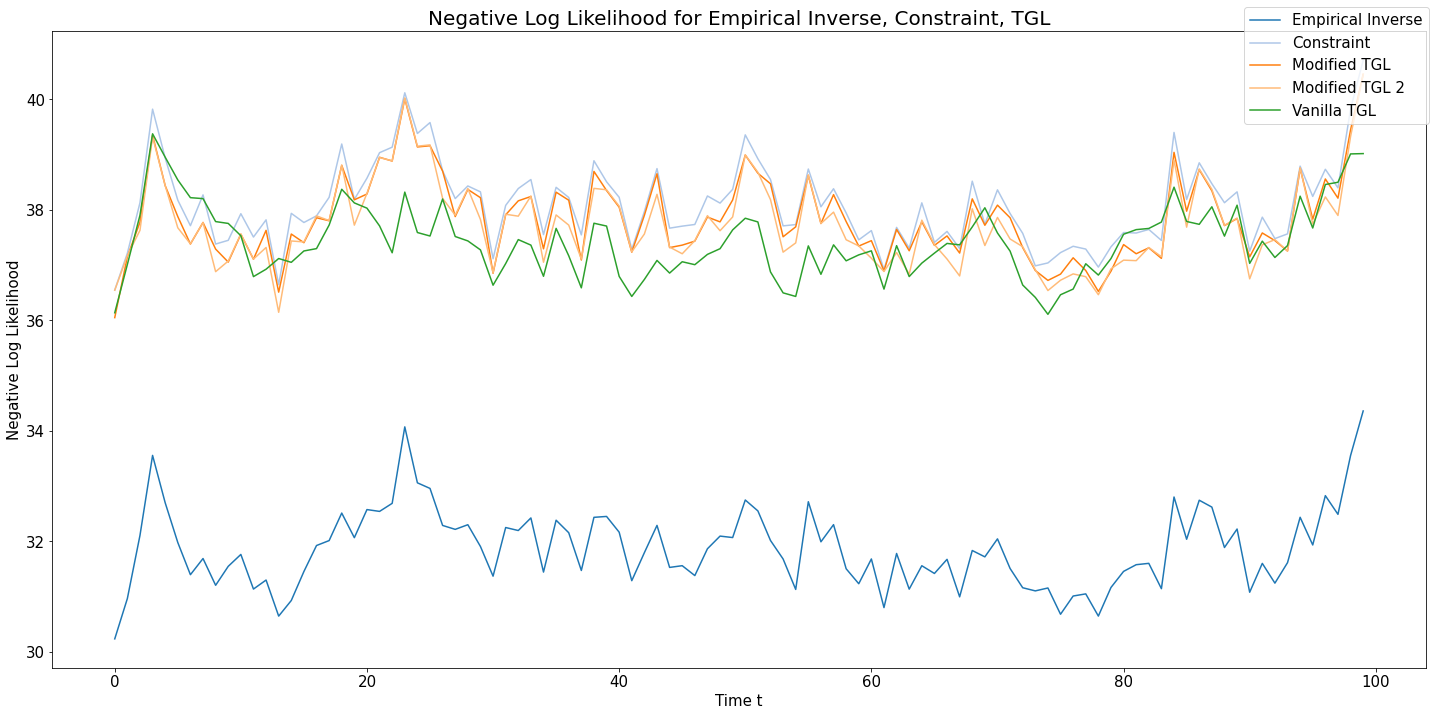

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), emp_inv_score, label=r'Empirical Inverse')
ax.plot(range(n_time), baseline_score, label=r'Constraint')
ax.plot(range(n_time), fit_score, label=r'Modified TGL')
ax.plot(range(n_time), _fit_score, label=r'Modified TGL 2')
ax.plot(range(n_time), fit_score_, label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_like_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), emp_inv_score, label=r'Empirical Inverse')
ax.plot(range(n_time), baseline_score, label=r'Constraint')
ax.plot(range(n_time), fit_score, label=r'Modified TGL')
ax.plot(range(n_time), fit_score_, label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_like_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), emp_inv_score, label=r'Empirical Inverse')
ax.plot(range(n_time), baseline_score, label=r'Constraint')
ax.plot(range(n_time), fit_score, label=r'TGL')

fig.legend(fontsize=15)
ax.set_ylabel('DTrace Loss', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'DTrace Loss for Empirical Inverse, Constraint, TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_like_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
np.mean([sum(sum(abs(pre[k]) > 0)) for k in range(n_time)])

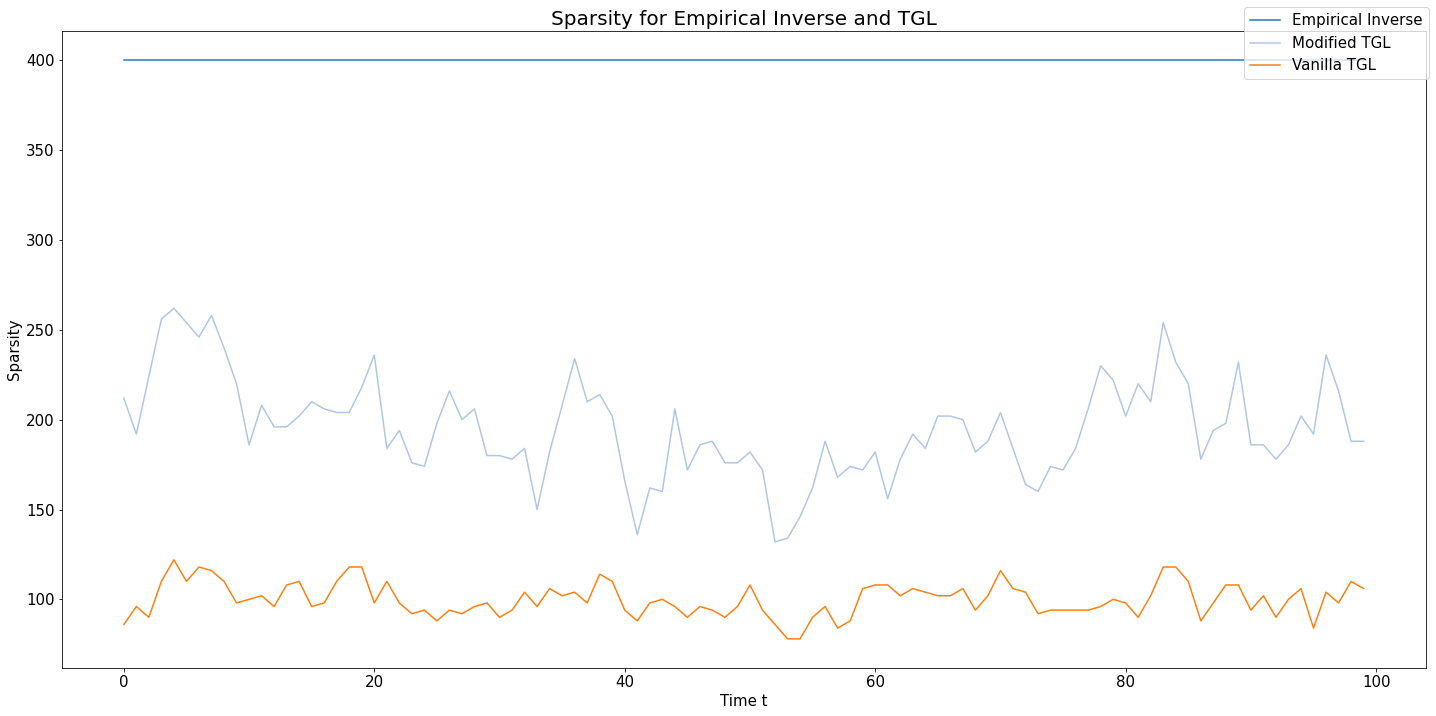

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0

ax.plot(range(n_time), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(n_time)], label=r'Empirical Inverse')
ax.plot(range(n_time), [sum(sum(abs(pre[k]) > 0)) for k in range(n_time)], label=r'Modified TGL')
# ax.plot(range(n_time), [sum(sum(abs(_pre[k]) > 0)) for k in range(n_time)], label=r'Modified TGL 2')
ax.plot(range(n_time), [sum(sum(abs(pre_[k]) > 0)) for k in range(n_time)], label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Sparsity', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Sparsity for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_supp_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0

ax.plot(range(n_time), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(n_time)], label=r'Empirical Inverse')
ax.plot(range(n_time), [sum(sum(abs(pre[k]) > 0)) for k in range(n_time)], label=r'Modified TGL')
ax.plot(range(n_time), [sum(sum(abs(pre_[k]) > 0)) for k in range(n_time)], label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Sparsity', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Sparsity for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_supp_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

diff_fit_ = [norm(pre_[k] - pre_[k-1], 'fro') for k in range(1, 100)]
diff_fit = [norm(pre[k] - pre[k-1], 'fro') for k in range(1, 100)]
diff_emp = [norm(tgl.emp_inv[k] - tgl.emp_inv[k-1], 'fro') for k in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_emp), alpha=1, label=r'Empirical Inverse')
ax.plot(range(1, n_time), np.array(diff_fit), alpha=1, label=r'Modified TGL')
ax.plot(range(1, n_time), np.array(diff_fit_), alpha=1, label=r'Vanilla TGL')

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_fro_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
print(np.mean(diff_fit), np.mean(diff_fit_))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

diff_fit_ = [norm(pre_[k] - pre_[k-1], 'fro') for k in range(1, 100)]
diff_fit = [norm(pre[k] - pre[k-1], 'fro') for k in range(1, 100)]
diff_emp = [norm(tgl.emp_inv[k] - tgl.emp_inv[k-1], 'fro') for k in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_emp), alpha=1, label=r'Empirical Inverse')
ax.plot(range(1, n_time), np.array(diff_fit), alpha=1, label=r'Modified TGL')
ax.plot(range(1, n_time), np.array(diff_fit_), alpha=1, label=r'Vanilla TGL')

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_fro_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

diff_fit_ = [norm(pre_[k] - pre_[k-1] - np.diag(np.diag(pre_[k] - pre_[k-1])), 'fro') for k in range(1, 100)]
diff_fit = [norm(pre[k] - pre[k-1] - np.diag(np.diag(pre[k] - pre[k-1])), 'fro') for k in range(1, 100)]
diff_emp = [norm(tgl.emp_inv[k] - tgl.emp_inv[k-1] - np.diag(np.diag(tgl.emp_inv[k] - tgl.emp_inv[k-1])), 'fro') for k in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_emp), alpha=1, label=r'Empirical Inverse')
ax.plot(range(1, n_time), np.array(diff_fit), alpha=1, label=r'Modified TGL')
ax.plot(range(1, n_time), np.array(diff_fit_), alpha=1, label=r'Vanilla TGL')

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_fro_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
print(diff_fit)

In [ ]:
print(diff_fit)